<a href="https://colab.research.google.com/github/thejarlid/makemore/blob/main/makemore_pt2/Makemore_pt2_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt

--2025-07-14 19:17:12--  https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.004s  

2025-07-14 19:17:12 (51.5 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()

In [ ]:
# build the vocabulary of characters and mappints to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [ ]:
# build the dataset

blocksize = 3 # context length: how many characters do we take to predict the next one
X, Y = [], []
for w in words:
  context = [0] * blocksize
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix] # crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

# training used for optimizing params
# validation used for development and tuning hyper parameters (size of embedding, strength of learning rate/regularization)
# test set is what we evaluate the actual model performance on at the end



In [ ]:
# build the data set

def build_dataset(words):
  blocksize = 3 # context length: how many characters do we take to predict the next one
  X, Y = [], []
  for w in words:
    context = [0] * blocksize
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
w1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
w2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, w1, b1, w2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
lri = []
lossi = []
stepi = []

In [ ]:
for i in range(200000):

  # minibatch construct (do 32 samples at a time)
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # [32, 3, 2] for each example we create an embedding for the 3 characters (each embedding is a dim of 2)
  h = torch.tanh(emb.view(-1, 30) @ w1 + b1) # (32, 100)
  logits = h @ w2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  lossi.append(loss.log10().item())
  stepi.append(i)

print(loss.item())

2.626563310623169


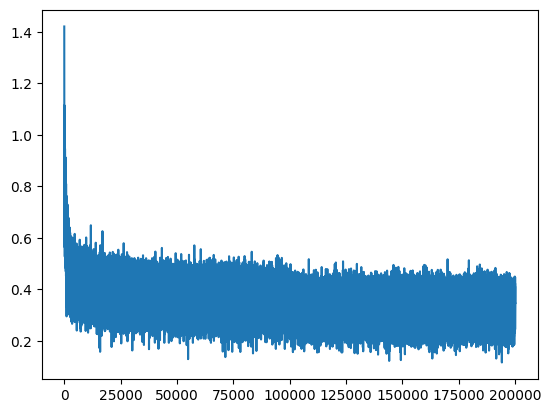

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
emb = C[Xtr] # [32, 3, 2] for each example we create an embedding for the 3 characters (each embedding is a dim of 2)
h = torch.tanh(emb.view(-1, 30) @ w1 + b1) # (32, 100)
logits = h @ w2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1319, grad_fn=<NllLossBackward0>)

In [ ]:
emb = C[Xdev] # [32, 3, 2] for each example we create an embedding for the 3 characters (each embedding is a dim of 2)
h = torch.tanh(emb.view(-1, 30) @ w1 + b1) # (32, 100)
logits = h @ w2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1803, grad_fn=<NllLossBackward0>)

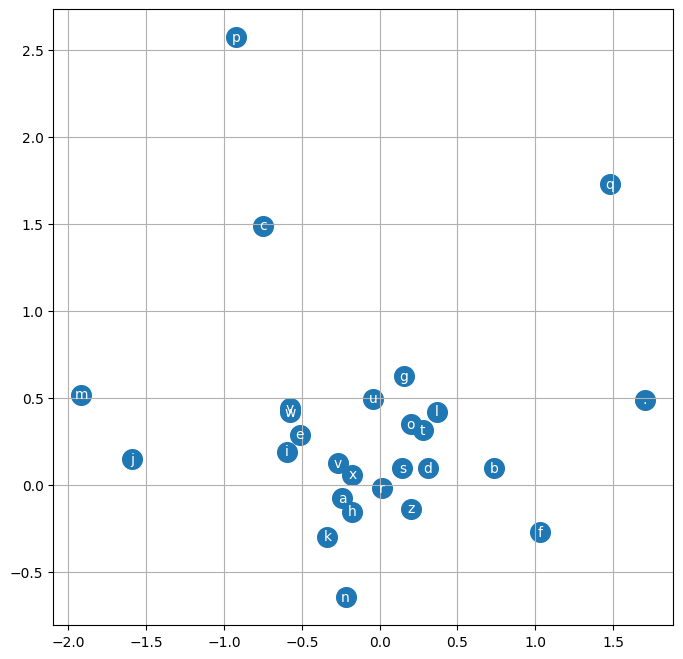

In [ ]:
# visualize embeddings
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

In [ ]:
# sample from the model
for _ in range(20):
  out = []
  context = [0] * blocksize
  while True:
    emb = C[torch.tensor([context])] # (1, blocksize, d)
    h = torch.tanh(emb.view(1, -1) @ w1 + b1)
    logits = h @ w2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

heraner.
tayveeracet.
jalisthrus.
kalidan.
aivian.
jishy.
malji.
triecilina.
kham.
esriygon.
nelynn.
emre.
ryle.
tad.
everricher.
sasp.
zai.
mir.
kendie.
amarelgin.
